## Cunningham and Yuter convective organization test over a 3 hour scene

This notebook tests the Cunningham and Yuter classification over one chosen 3 hour scene.

In [145]:
import pyart
import gzip
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import rcParams
from scipy import ndimage
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import glob
import re
import time
from copy import deepcopy
from IPython.display import Image, display
%matplotlib inline
import multidop
from mpl_toolkits import basemap
from skimage import feature, morphology

In [146]:
# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 19
start_month = 1
start_hour = 23
start_minute = 50
start_second = 0

end_year = 2006
end_month = 1
end_day = 20
end_hour = 3
end_minute = 0
end_second = 0

data_path_cpol = '/home/rjackson/data/radar/cpol/'

This looks for all of the available timeperiods in the data_path directory and pulls out
the file names that match the given time periods above.

In [147]:
# get_radar_times_cpol
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_cpol(start_year, start_month, start_day,
                         start_hour, start_minute, end_year,
                         end_month, end_day, end_hour, 
                         end_minute, minute_interval=5):

    from datetime import timedelta, datetime
    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )  

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = range(0, no_days)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_cpol +
                      'Gunn_pt_' +
                      year_str +
                      month_str +
                      day_str +
                     '*.uf')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(data_path_cpol +
                             'Gunn_pt_' +
                              year_str +
                              month_str +
                              day_str +
                              '*.uf')
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-26:-12]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = date_str[12:14]
        
        
        
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                   
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_cpol(time):
    from datetime import timedelta, datetime
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_cpol +
                     'Gunn_pt_' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str +
                     second_str +
                     '_PPI_deal.uf')
    radar = pyart.io.read_uf(file_name_str)
    return radar

In [148]:
# Plot the radars from given time.

times = get_radar_times_cpol(start_year, start_month, start_day,
                             start_hour, start_minute, end_year,
                             end_month, end_day, end_hour, 
                             end_minute, minute_interval=10)

We are about to load grid files for 2 days
Looking for files with format /home/rjackson/data/radar/cpol/Gunn_pt_20060119*.uf
Looking for files with format /home/rjackson/data/radar/cpol/Gunn_pt_20060120*.uf


Test Steiner convective classification on scan

In [149]:
frame_number = 6
Radar = get_radar_from_cpol(times[frame_number])

print('Calculating texture....')
nyq_Gunn = Radar.instrument_parameters['nyquist_velocity']['data'][0]

data = ndimage.filters.generic_filter(Radar.fields['velocity']['data'],
                                      pyart.util.interval_std, size = (6,6),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data

Radar.add_field('velocity_texture', texture_field, replace_existing = True)

Calculating texture....


In [150]:
gatefilter_Gunn = pyart.correct.GateFilter(Radar)
gatefilter_Gunn.exclude_above('velocity_texture', 4)

In [151]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=4.0, nb=1.5,
               fields=['DT', 'VT'], origin=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        weighting_function='Cressman',
        gridding_algo='map_gates_to_grid',
        h_factor=h_factor,
        min_radius=min_radius,
        bsp=bsp,
        nb=nb)
    print(time.time() - bt, 'seconds to grid radar')
    return grid

In [152]:
# Change variable names to DT (reflectivity) and VT (velocity) expected by multidop
# If you needed to dealias or perform other corrections,
# this would be the time to start doing that.
# Both datasets already have aliasing corrections
cp = deepcopy(Radar.fields['corrected_reflectivity']['data'])
texture = Radar.fields['velocity_texture']['data']

# Apply texture filter to CPOL data
cp = np.ma.masked_where(texture > 4, cp)
Radar.add_field_like('corrected_reflectivity', 'reflectivity', cp, replace_existing=True)

grid_cpol = grid_radar(Radar, 
                       origin=(Radar.latitude['data'][0], Radar.longitude['data'][0]),
                       xlim=(-150000, 150000), ylim=(-150000, 150000), 
                       fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                       h_factor=2.0,
                       zlim=(500, 20000), grid_shape=(40, 121, 121))

1.3026823997497559 seconds to grid radar


Test Steiner classification

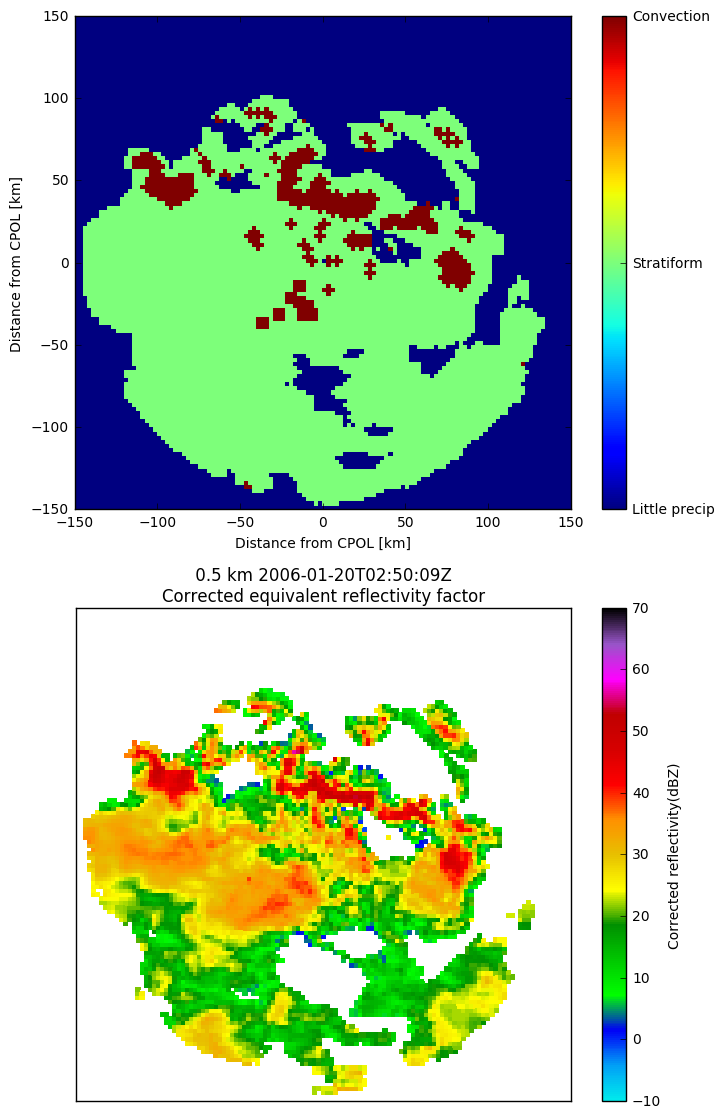

In [159]:
convective = pyart.retrieve.steiner_conv_strat(grid_cpol)
#grid_cpol.add_field('conv_strat', convective)

plt.figure(figsize=(8,14))
plt.subplot(211)
x,y = np.meshgrid(grid_cpol.x['data'], grid_cpol.y['data'])
plt.pcolormesh(x/1e3,y/1e3,convective['data'])
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')

cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Little precip', 'Stratiform', 'Convection'])
plt.subplot(212)


CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol)
CPOLGridDisplay.plot_grid('reflectivity', 0, vmin=-10, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)

# Calculate parameters needed for classification for whole period

In [154]:
opportunities = len(times)

precip_types = np.ma.zeros((opportunities, len(grid_cpol.x['data']), len(grid_cpol.y['data'])))

i = 0
for t in times:
    Radar = get_radar_from_cpol(t)

    print('Calculating texture....')
    nyq_Gunn = Radar.instrument_parameters['nyquist_velocity']['data'][0]

    data = ndimage.filters.generic_filter(Radar.fields['velocity']['data'],
                                          pyart.util.interval_std, size = (6,6),
                                          extra_arguments = (-nyq_Gunn, nyq_Gunn))
    filtered_data = ndimage.filters.median_filter(data, size = (4,4))
    texture_field = pyart.config.get_metadata('velocity')
    texture_field['data'] = filtered_data

    Radar.add_field('velocity_texture', texture_field, replace_existing = True)
    cp = deepcopy(Radar.fields['corrected_reflectivity']['data'])
    texture = Radar.fields['velocity_texture']['data']

    # Apply texture filter to CPOL data
    cp = np.ma.masked_where(texture > 4, cp)
    Radar.add_field_like('corrected_reflectivity', 'reflectivity', cp, replace_existing=True)

    grid_cpol = grid_radar(Radar, 
                           origin=(Radar.latitude['data'][0], Radar.longitude['data'][0]),
                           xlim=(-150000, 150000), ylim=(-150000, 150000), 
                           fields=['reflectivity'], min_radius=750.0, bsp=1.0, nb=1.5,
                           h_factor=2.0,
                           zlim=(500, 20000), grid_shape=(40, 121, 121))
    
    convective = pyart.retrieve.steiner_conv_strat(grid_cpol)
    precip_types[i,:,:] = convective['data']
    i = i + 1    

Calculating texture....
1.5514767169952393 seconds to grid radar
Calculating texture....
1.5363855361938477 seconds to grid radar
Calculating texture....
1.3095285892486572 seconds to grid radar
Calculating texture....
1.2704105377197266 seconds to grid radar
Calculating texture....
1.311392068862915 seconds to grid radar
Calculating texture....
1.5139503479003906 seconds to grid radar
Calculating texture....
1.2688367366790771 seconds to grid radar
Calculating texture....
1.2686443328857422 seconds to grid radar
Calculating texture....
1.26664137840271 seconds to grid radar
Calculating texture....
1.4620349407196045 seconds to grid radar
Calculating texture....
1.2606942653656006 seconds to grid radar
Calculating texture....
1.2629117965698242 seconds to grid radar
Calculating texture....
1.2875754833221436 seconds to grid radar
Calculating texture....
1.3596675395965576 seconds to grid radar
Calculating texture....
1.2824630737304688 seconds to grid radar
Calculating texture....
1.26

In [155]:
total_frequency = np.zeros((len(grid_cpol.x['data']), 
                           len(grid_cpol.y['data'])))
convective_frequency = np.zeros((len(grid_cpol.x['data']), 
                                 len(grid_cpol.y['data'])))
total_changes = np.zeros((len(grid_cpol.x['data']), 
                          len(grid_cpol.y['data'])))
intermittency = np.zeros((len(grid_cpol.x['data']), 
                          len(grid_cpol.y['data'])))
modes = np.zeros((len(grid_cpol.x['data']), 
                  len(grid_cpol.y['data'])))

for j in range(0, len(grid_cpol.x['data'])):
    for k in range(0, len(grid_cpol.y['data'])):
        ptypes = np.squeeze(precip_types[:,j,k])
        total_frequency[j,k] = sum(np.where(ptypes > 0, 1, 0))
        if(total_frequency[j,k] > 0):
            convective_frequency[j,k] = float(sum(np.where(ptypes == 2, 1, 0))) / float(total_frequency[j,k])
        changes = np.zeros(ptypes.shape)
        changes[1:] = np.diff(ptypes)
        changes[ptypes == 0] = 0
        total_changes[j,k] = sum(changes[ptypes > 0])
        intermittency[j,k] = float(total_changes[j,k])/float(opportunities)
        if(convective_frequency[j,k] < 0.33):
            modes[j,k] = 1
        elif(convective_frequency[j,k] > 0.33 and
             convective_frequency[j,k] < 0.66 and
             intermittency[j,j] > 0.33):
            modes[j,k] = 2
        elif(convective_frequency[j,k] > 0.66):
            modes[j,k] = 3
        else:
            modes[j,k] = 4
        
        # Little precipitation periods
        if(float(total_frequency[j,k])/float(opportunities) < 0.3):
            modes[j,k] = 0

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Stratiform!


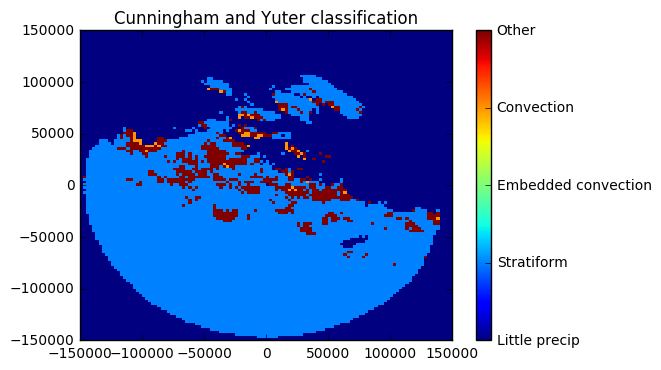

In [164]:
print(ptypes)
plt.figure
plt.pcolormesh(x,y,modes)
cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(['Little precip', 'Stratiform', 'Embedded convection', 'Convection', 'Other'])  
plt.title('Cunningham and Yuter classification')

total_points = len(np.where(modes > 0))
total_stratiform = len(np.where(modes == 1))
total_embedded = len(np.where(modes == 2))
total_convective = len(np.where(modes == 3))
total_other = len(np.where(modes == 4))

if(float(total_stratiform)/float(total_points) > 0.25):
    print('Stratiform!')
elif(float(total_convective)/float(total_points) > 0.25):
    print('Convective!')
elif(float(total_embedded)/float(total_points) > 0.25):    
    print('Embedded convection!')
else:
    print('Other!')